# **Pairs Trading Project: Exploring Market Neutrality and Statistical Arbitrage**

This project explores pairs trading using a class-based approach in Python. We will manipulate data with pandas, visualize it with matplotlib and seaborn, perform regression with sklearn, and conduct statistical testing with statsmodels.


## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import yfinance as yf

# Set the aesthetic style of the plots
sns.set_style("darkgrid")

## 1. Define the PairsTrade Class
The `PairsTrade` class encapsulates functionality for pairs trading:
- **Download Data**: Fetch historical prices using Yahoo Finance.
- **Calculate Spread**: Use linear regression to find the hedge ratio and calculate the spread.
- **Check Stationarity**: Perform the Augmented Dickey-Fuller (ADF) test to check if the spread is stationary.
- **Plot Data**: Visualize historical prices and the spread.


**Definitions**:
- **Pairs Trading**: A market-neutral strategy involving matching a long position with a short position in a pair of highly correlated stocks.
- **Hedge Ratio**: The ratio used to maintain a market-neutral position (found through an OLS linear regression)

In [6]:
class PairsTrade:

    def __init__(self, ticker_list, start_date, end_date, thresh='5%', max_lag=1):
        """
        Initialize the PairsTrade class.

        Parameters:
        ticker_list (list): List of tickers (strings).
        start_date (str): Start date for data (format 'YYYY-MM-DD').
        end_date (str): End date for data (format 'YYYY-MM-DD').
        thresh (str): Threshold for ADF test (default '5%').
        max_lag (int): Max lag for ADF test (default 1).
        """
        self.ticker_list = ticker_list
        self.start_date = start_date
        self.end_date = end_date
        self.thresh = thresh
        self.max_lag = max_lag
        self.df = self.download_data()
        self.hedge_ratio = self.spread_calc()
        self.is_stationary = self.check_stationary()

    def download_data(self):
        """
        Download data for the given tickers.

        Returns:
        DataFrame: DataFrame containing the asset prices.
        """
        df = pd.DataFrame()
        for ticker in self.ticker_list:
            data = yf.download(ticker, start=self.start_date, end=self.end_date)
            df[ticker] = data['Close']
        df = df.dropna()
        return df

    def spread_calc(self):
        """
        Calculate the spread of the pairs using linear regression.

        Returns:
        float: Hedge ratio.
        """
        model = LinearRegression().fit(self.df[self.ticker_list[1]].values.reshape(-1, 1), self.df[self.ticker_list[0]].values)
        hedge_ratio = model.coef_[0]
        self.df['spread'] = self.df[self.ticker_list[0]] - hedge_ratio * self.df[self.ticker_list[1]]
        return hedge_ratio

    def plot_data(self):
        """
        Plot the price data of the tickers.
        """
        plt.figure(figsize=(18, 10))
        sns.lineplot(data=self.df[self.ticker_list])
        plt.title(f'Price of {self.ticker_list[0]} and {self.ticker_list[1]}')
        plt.show()

    def plot_spread(self, plot_price=False):
        """
        Plot the spread (and prices if specified).

        Parameters:
        plot_price (bool): Whether to plot prices along with the spread (default False).
        """
        if plot_price:
            fig, ax = plt.subplots(nrows=2, figsize=(18, 10))
            sns.lineplot(data=self.df['spread'], ax=ax[0])
            ax[0].set_title(f'Spread of {self.ticker_list[0]} - {self.hedge_ratio:.2f} * {self.ticker_list[1]}')
            sns.lineplot(data=self.df[self.ticker_list], ax=ax[1])
            ax[1].set_title('Price')
            ax[1].legend(self.ticker_list)
        else:
            plt.figure(figsize=(18, 10))
            sns.lineplot(data=self.df['spread'])
            plt.title(f'Spread of {self.ticker_list[0]} - {self.hedge_ratio:.2f} * {self.ticker_list[1]}')
            plt.ylabel('Spread')
            plt.show()

    def check_stationary(self):
        """
        Check if the spread is stationary using ADF test.

        Returns:
        bool: True if the spread is stationary, False otherwise.
        """
        adf_result = adfuller(self.df['spread'], maxlag=self.max_lag)
        test_stat = adf_result[0]
        t_stat = adf_result[4][self.thresh]
        return test_stat < t_stat


## 2. Initialize the PairsTrade Class and Download Data
Create an instance of the `PairsTrade` class with the tickers for SPY and QQQ, specifying the date range for historical data. The class will automatically download the data and perform initial calculations.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


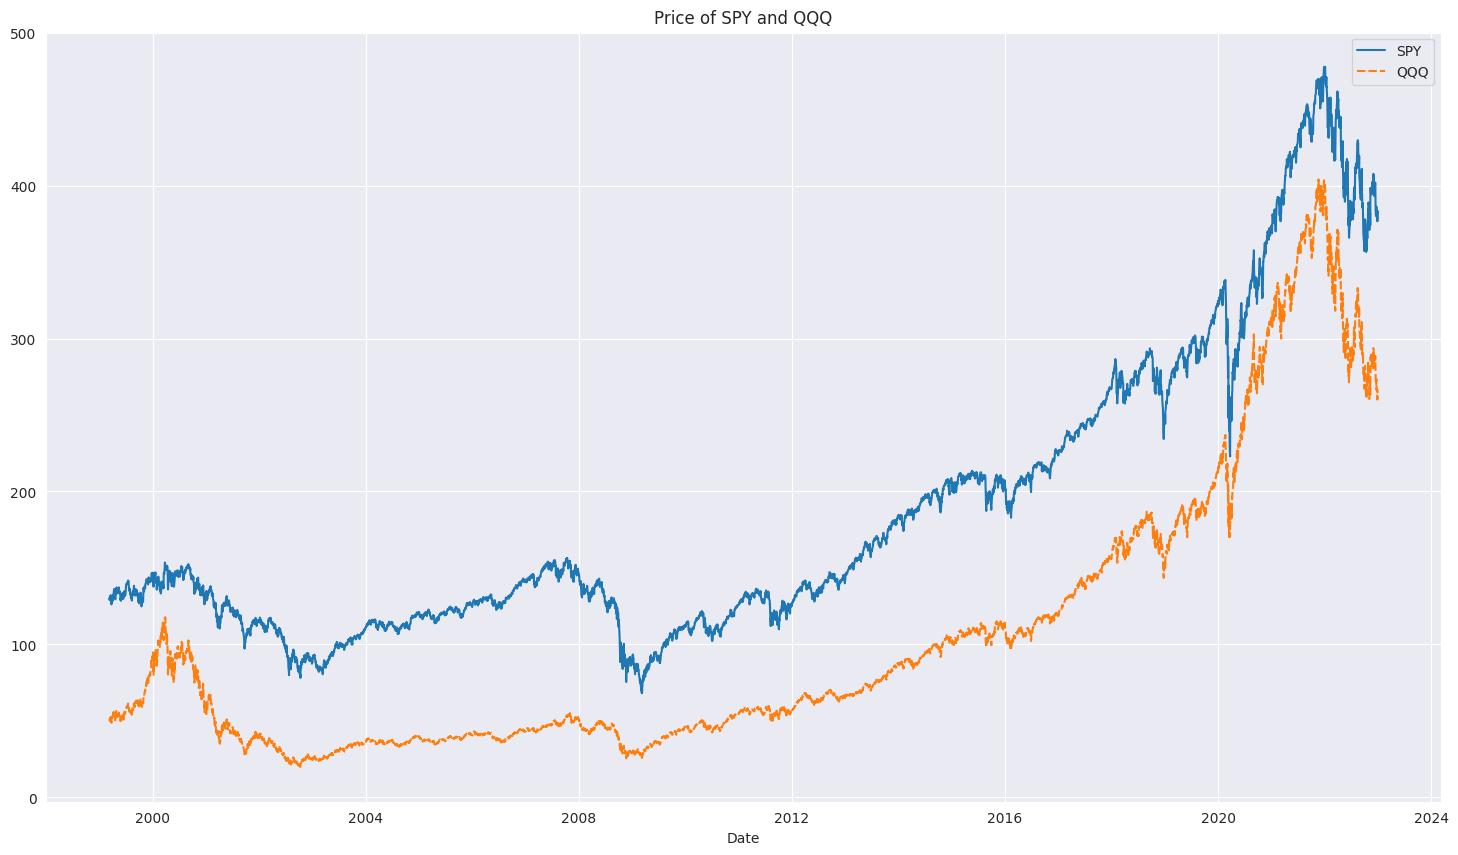

In [11]:
# Initialize the PairsTrade class
pairs_trade = PairsTrade(['SPY', 'QQQ'], start_date='1999-01-01', end_date='2023-01-01')

# Plot the price data
pairs_trade.plot_data()


## 3. Calculate the Spread and Check for Stationarity


Calculate the spread between two assets by performing a linear regression:

$$ \text{spread} = P_{1} - \beta \cdot P_{2} $$

where $ P_{1} $ and $ P_{2} $ are the prices of the two assets, and \( \beta \) is the **hedge ratio**. The hedge ratio is obtained by regressing the price of one asset against the other:

$$ P_{1} = \alpha + \beta P_{2} + \epsilon $$

In this regression equation:
- $ \alpha $ is the intercept,
- $ \beta $ is the slope coefficient (hedge ratio),
- $ \epsilon $ is the error term.

The hedge ratio $ \beta $ represents the amount of asset $ P_{2} $ needed to hedge against the price movements of asset $ P_{1} $

The **ADF test** checks if the spread is stationary by testing the null hypothesis that a unit root is present. If the test statistic is less than the critical value, the null hypothesis is rejected, indicating that the spread is stationary.


Is the spread stationary? False


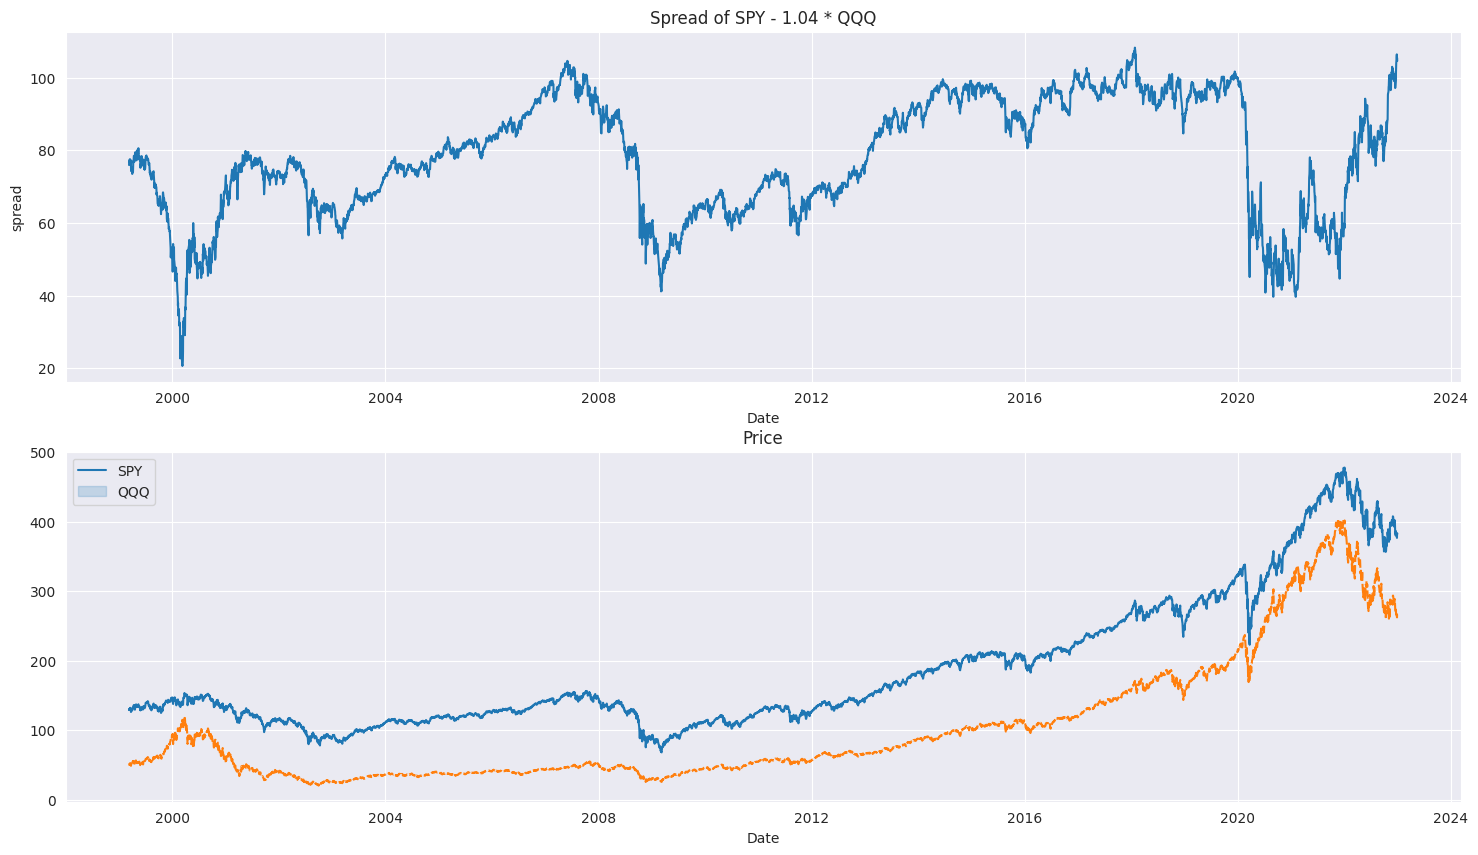

In [12]:
# Plot the spread with prices
pairs_trade.plot_spread(plot_price=True)

# Print if the spread is stationary
print('Is the spread stationary?', pairs_trade.is_stationary)


In [13]:
print('Hedge Ratio:', pairs_trade.hedge_ratio)
print('Is the spread stationary?', pairs_trade.is_stationary)


Hedge Ratio: 1.0434447355593648
Is the spread stationary? False


## **Conclusion**

**Pairs trading** offers an effective market-neutral strategy by leveraging statistical relationships between pairs of assets. The theory behind pairs trading is in **cointegration** and **stationarity**. When two asset prices are cointegrated, it implies that their price movements share a long-term equilibrium relationship, despite any short-term deviations. This relationship can be exploited for profit by identifying **stationary** spreads.

### Theory and Practical Implications

The fundamental theory of pairs trading revolves around the concept of **mean reversion**. If two assets are cointegrated, their price spread will fluctuate around a mean. By trading on these fluctuations, we can profit when the spread reverts to its mean. This theory is sound because financial markets often exhibit mean-reverting behavior due to factors like arbitrage opportunities and market efficiency.

The theory behind pairs trading is rooted in the concept of **cointegration** and stochastic processes. When two asset prices are cointegrated, their price movements share a long-term equilibrium relationship, despite short-term deviations. This can be modeled using the **Ornstein-Uhlenbeck process**, a type of stochastic process that captures mean-reverting behavior:

$$ dX_t = \theta (\mu - X_t) dt + \sigma dW_t $$

where:
- $ X_t $ is the spread at time $ t $
- $ \mu $ is the mean level,
- $ \theta $ is the speed of mean reversion,
- $ \sigma $ is the volatility,
- $ dW_t $ is a Wiener process (Brownian motion).

### Testing and Application

This strategy can be tested and applied to various markets beyond equities, including commodities, currencies, and fixed income. Additionally, pairs trading can be extended to portfolios, where you trade one portfolio against another rather than individual assets. For example:
- **Equity Pairs**: Trading SPY (S&P 500 ETF) against QQQ (NASDAQ 100 ETF).
- **Commodity Pairs**: Trading gold against silver.
- **Currency Pairs**: Trading EUR/USD against GBP/USD.
- They must be cointegrated.

### Example: Simple Mean Reversion Strategy (Bollinger Bands sorta)

Consider two cointegrated assets, Asset A and Asset B. If the spread (difference) between their prices deviates from the historical mean by a significant margin (e.g., one or two standard deviations), we can execute a pairs trade:
1. **Calculate the Spread**:
   $$ \text{spread} = P_A - \beta \cdot P_B $$
   where $ P_A $ and $ P_B $ are the prices of Asset A and Asset B, respectively, and $ \beta $ is the hedge ratio.
2. **Identify Deviation**: If the spread deviates from the mean by more than a predefined threshold.
3. **Execute Trade**: Go long on the underperforming asset and short on the outperforming asset.
4. **Mean Reversion**: Close the positions when the spread reverts to the mean.

To trade this strategy effectively, you would go **long** on the asset that is currently undervalued (trading below its historical relationship with the other asset) and **short** the asset that is overvalued (trading above its historical relationship). This way, when the spread reverts to the mean, the position profits from the price adjustments of both assets. Essentially, we can design our own markets by selecting pairs or portfolios that exhibit strong cointegration, allowing us to capitalize on (somewhat) predictable mean-reverting behavior.